In [1]:
import itertools
import pickle

import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch
import pickle
from pathlib import Path

import chess
import iceberg as ice
import matplotlib.pyplot as plt
import numpy as np
import torch
from leela_interp import Lc0Model, Lc0sight, LeelaBoard
from leela_interp.core.iceberg_board import palette
from leela_interp.tools import figure_helpers as fh
from leela_interp.tools.piece_movement_heads import (
    bishop_heads,
    knight_heads,
    rook_heads,
)

/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ..

/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp


/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

## Note: this plotting code is mostly copypasted from one of the deleted notebooks.

In [5]:
SETTING_TO_PRETTY_NAME = {
    "main": "Probe on trained model",
    "random_model": "Probe on random model",
}


def plot_probe_results(split="all",title="Third move prediction",nseeds=5):
    fh.set(fast=False)
    plt.figure(figsize=(fh.HALF_WIDTH, 2))

    for i, setting in enumerate(["main", "random_model"]):
        results = np.zeros((15, 5))
        for seed in range(nseeds):
            with open(f"results/probing/{split}/{seed}/{setting}.pkl", "rb") as f:
                new_results = pickle.load(f)
                results[:, seed] = new_results["accuracies"]

        means = results.mean(1)
        squared_seed_errors = results.var(1) / results.shape[1]
        # Size of the eval dataset is 30% of all puzzles
        squared_acc_errors = means * (1 - means) / (0.3 * len(puzzles))
        # 2 sigma errors
        errors = 2 * np.sqrt(squared_seed_errors + squared_acc_errors)

        max_layer = means.argmax()

        print(
            f"Max accuracy ({setting}, L{max_layer}): {means[max_layer]:.2f} +- {errors[max_layer]:.2f}"
        )
        plt.plot(
            means,
            label=SETTING_TO_PRETTY_NAME[setting],
            color=fh.COLORS[i],
            linewidth=fh.LINE_WIDTH,
        )
        plt.fill_between(
            range(15),
            means - errors,
            means + errors,
            color=fh.COLORS[i],
            alpha=fh.ERROR_ALPHA,
            linewidth=0,
        )

    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.ylim(0, 1.0)
    plt.xlim(0, 14)
    plt.gca().spines[:].set_visible(False)
    plt.gca().set_facecolor(fh.PLOT_FACE_COLOR)
    plt.grid(linestyle="--")
    plt.grid(which="minor", alpha=0.3, linestyle="--")

# Train and eval probes

Made some modifications to probing.py but its mostly from the paper too.

In [6]:
!python scripts/probing.py --random --n_seeds 5 --n_puzzles 500 
!python scripts/probing.py --main --n_seeds 5 --n_puzzles 500 

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:52<00:00, 52.80s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:11<00:00,  1.28it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  3.78it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

Max accuracy (main, L13): 0.77 +- 0.02
Max accuracy (random_model, L6): 0.12 +- 0.01


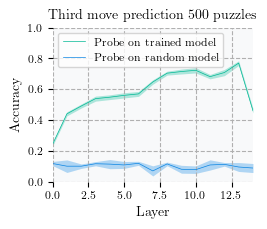

In [7]:
plot_probe_results(title="Third move prediction 500 puzzles")

# Interestign result on 1 move board

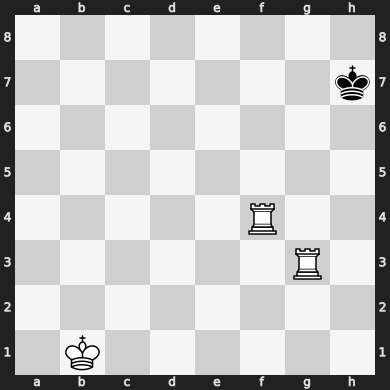

In [8]:

puzzle = "8/7k/8/8/5R2/6R1/8/1K6"

#puzzle ="8/8/8/8/3K4/7k/3R4/6Q1"
#http://www.netreal.de/Forsyth-Edwards-Notation/index.php found this page that can be used to make them.

board = LeelaBoard.from_fen(puzzle)
board

In [9]:
model = Lc0sight("lc0.onnx", device=device)
with open("results/probing/all/0/target_probes.pkl", "rb") as f:
    target_probes = pickle.load(f)

Using device: cuda


In [10]:
model.pretty_play(board)

Rh4#: 6.77%
Rf2: 4.39%
Ka1: 4.31%
Kc1: 4.31%
Rd4: 4.16%
W: 99.86%, D: 0.14%, L: 0.00%


In [11]:
layer = 12
head =  12

with model.trace(board):
    attention = model.attention_scores(layer).output[0, head].save()
attention.shape

torch.Size([64, 64])

This atention plotting code is from the demo notebook.

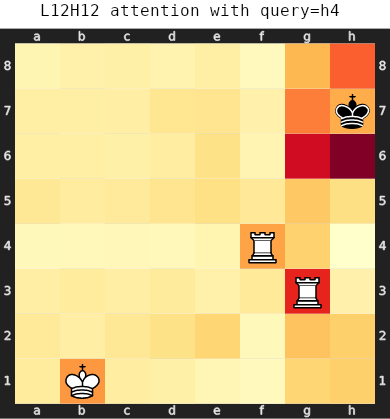

In [12]:
square = f"h4"
idx = board.sq2idx(square)
board.plot(attention[idx], caption=f"L{layer}H{head} attention with query={square}")

I did write this next function it ouptputs the probabilities from the probe.

In [13]:
def target_probe_prediction(target_probes,first_move_target,layer = 12):
    if isinstance(first_move_target, str): 
        first_move_target_n=board.sq2idx(first_move_target)
    else:
        first_move_target_n=first_move_target
    with model.trace(board):
        residual_stream = model.residual_stream(layer).output.save()

    X = residual_stream
    Z = X[np.arange(len(X)), [first_move_target_n], :]
    return target_probes[layer].predict_proba(X, Z)

In [14]:
third_move_target= "h4"
third_move_target_n=board.sq2idx(third_move_target)

/media/victor/F8D25071D25035DA/Alingment/lela-interp/leela-interp/src/leela_interp/tools/probing.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z_pt = torch.tensor(Z, dtype=torch.float32, device=device)


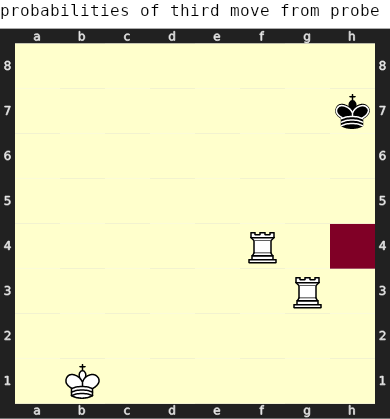

In [15]:
board.plot(target_probe_prediction(target_probes,"h4",layer=10)[0], caption="probabilities of third move from probe")

In [18]:
!python scripts/probing.py --random  --n_seeds 10 --n_puzzles 500 --rand_z
!python scripts/probing.py --main  --n_seeds 10 --n_puzzles 500  --rand_z

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.88s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:18<00:00,  1.24s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.11it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

Max accuracy (main, L13): 0.45 +- 0.03
Max accuracy (random_model, L2): 0.02 +- 0.01


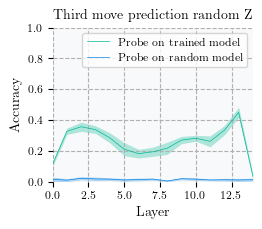

In [22]:
plot_probe_results(title="Third move prediction random Z")

In [23]:
puzzle = puzzles.iloc[483]#using the puzzle from the paper
board = LeelaBoard.from_puzzle(puzzle)

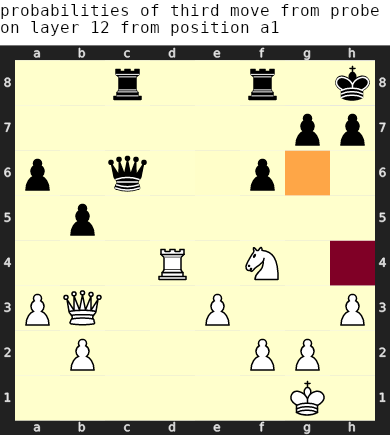

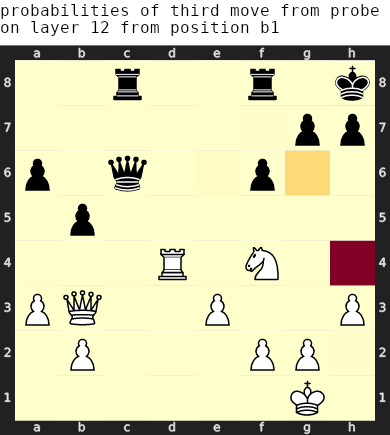

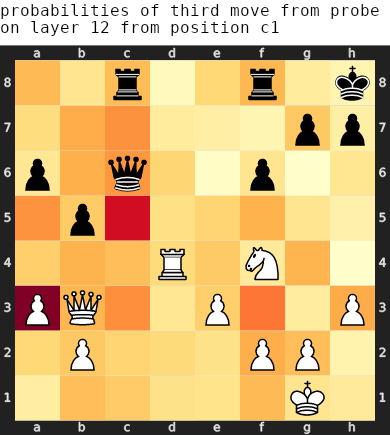

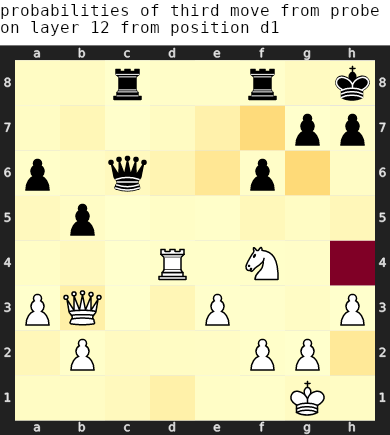

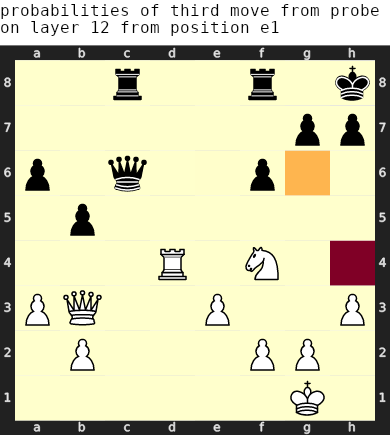

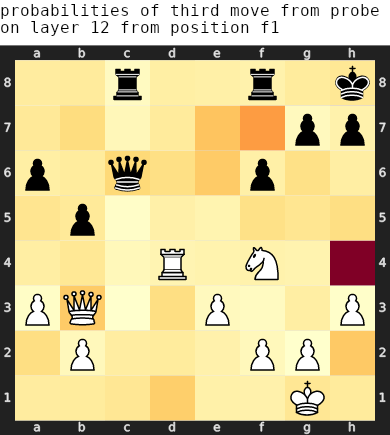

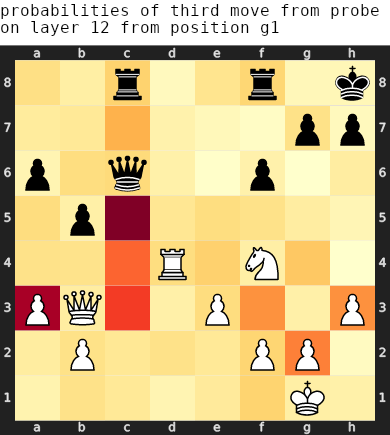

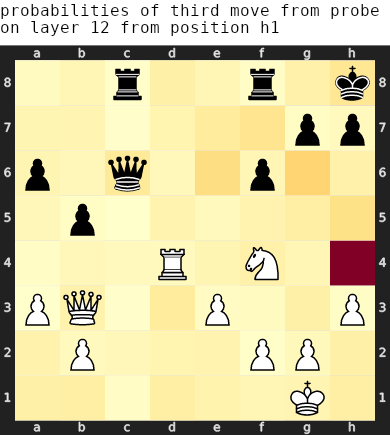

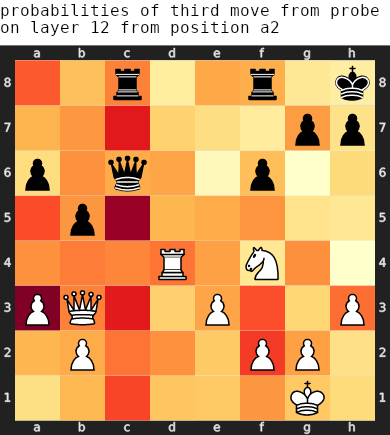

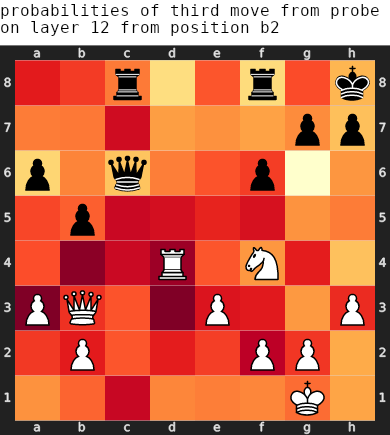

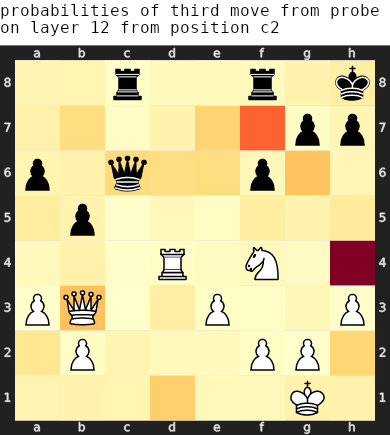

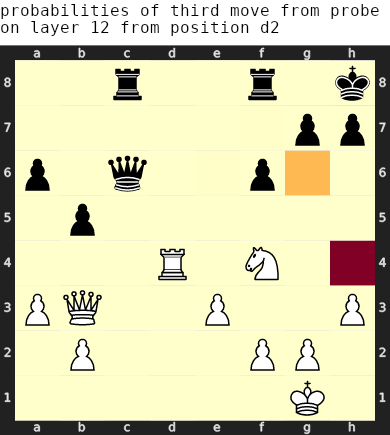

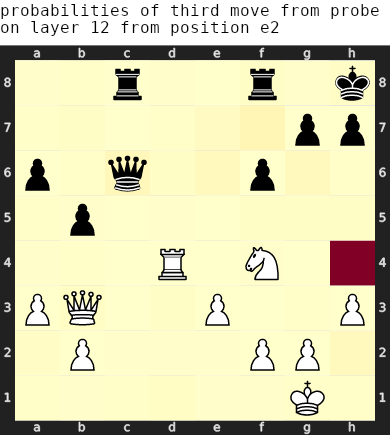

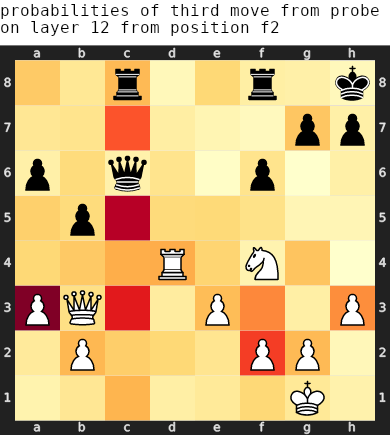

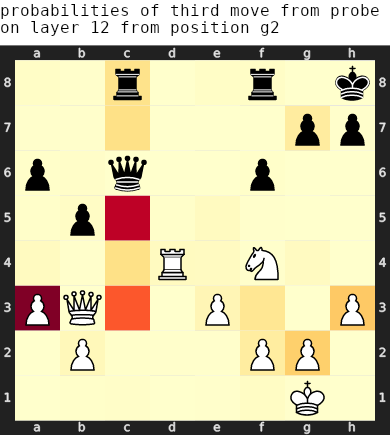

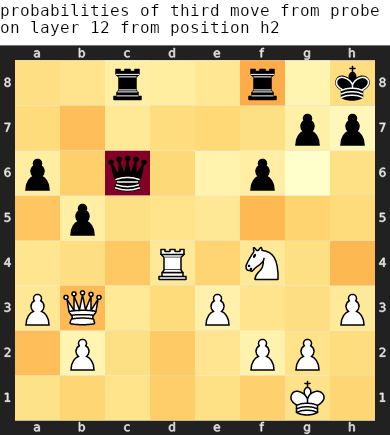

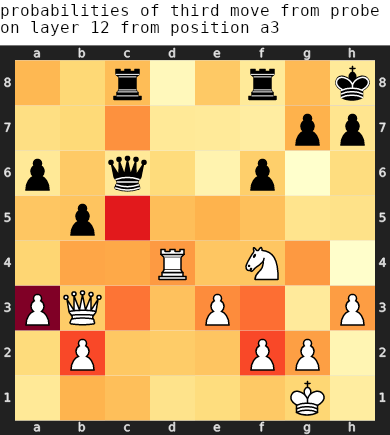

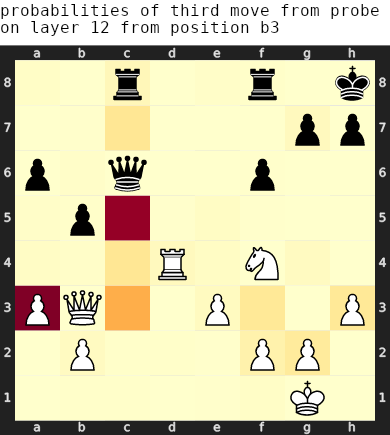

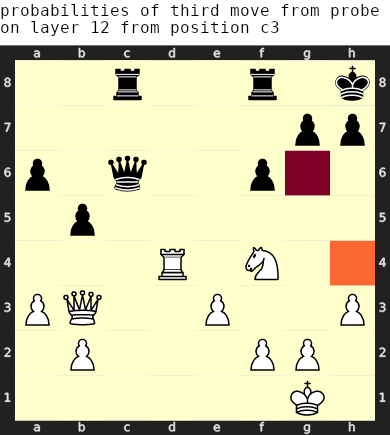

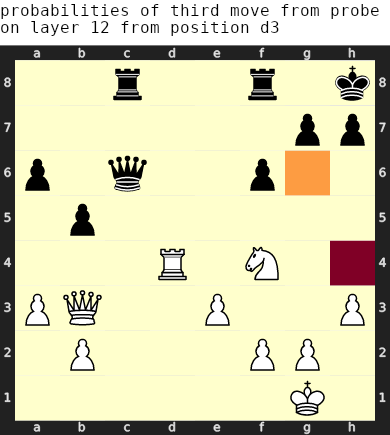

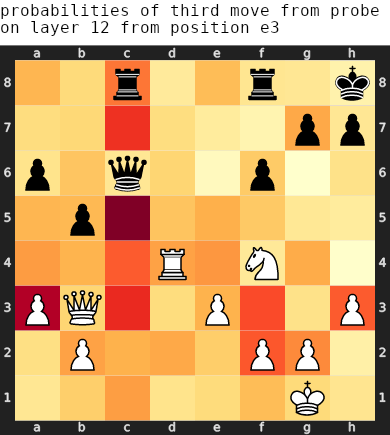

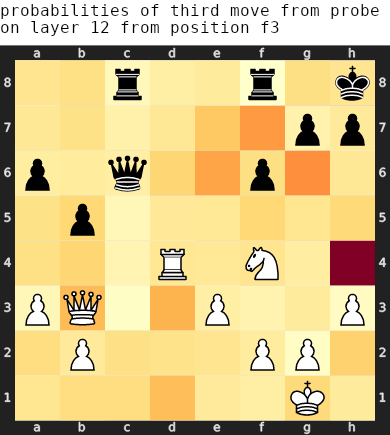

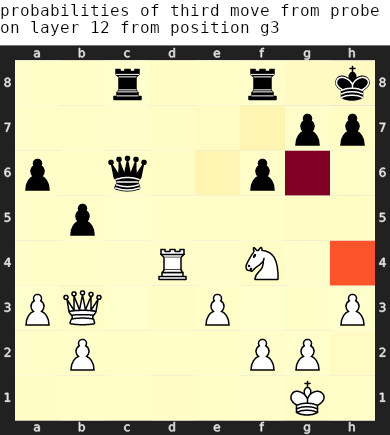

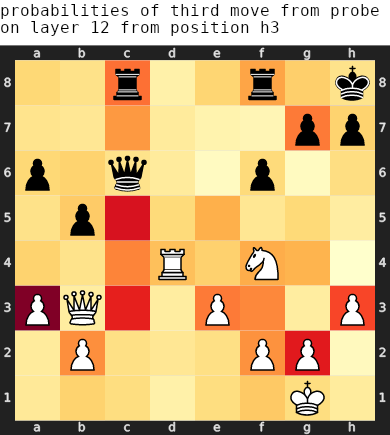

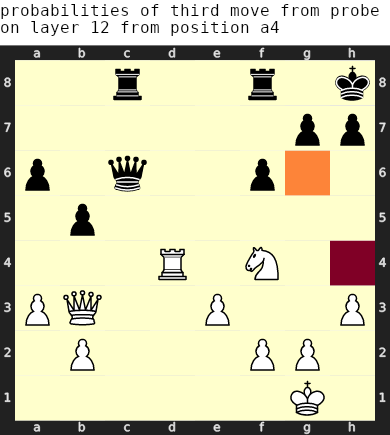

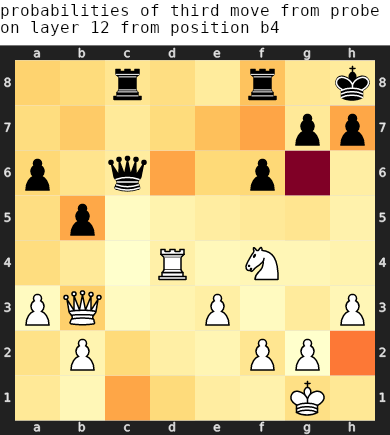

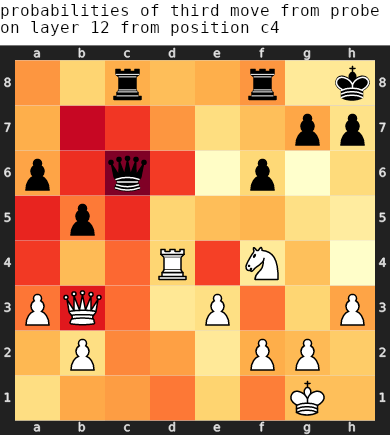

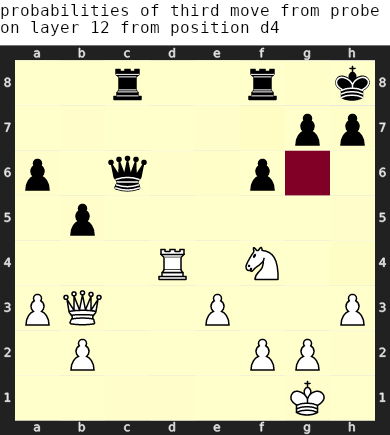

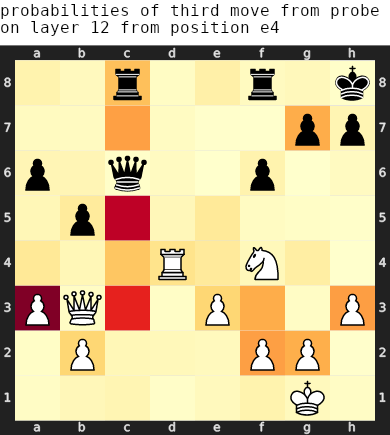

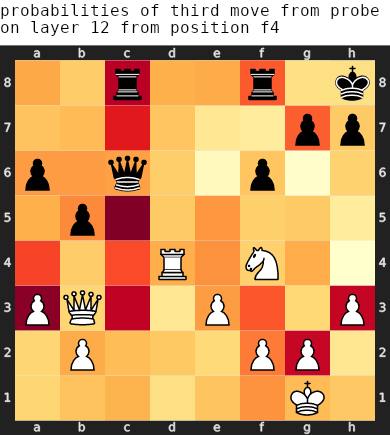

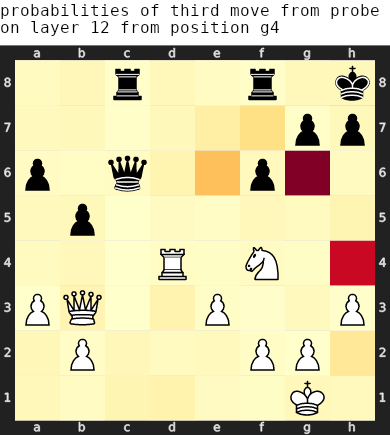

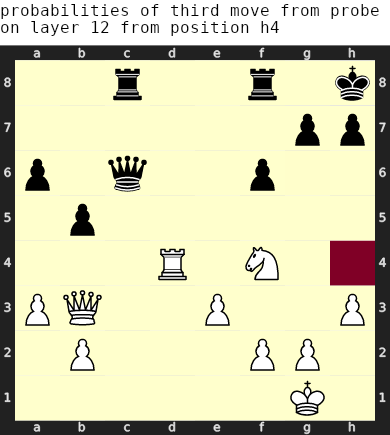

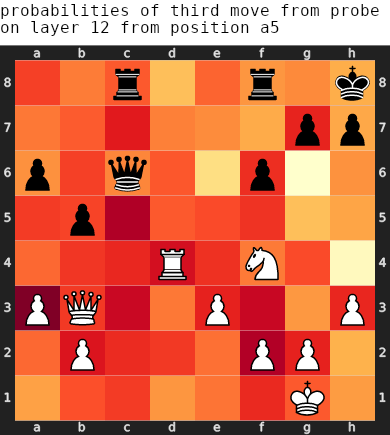

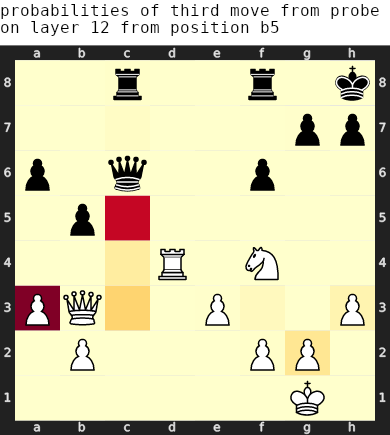

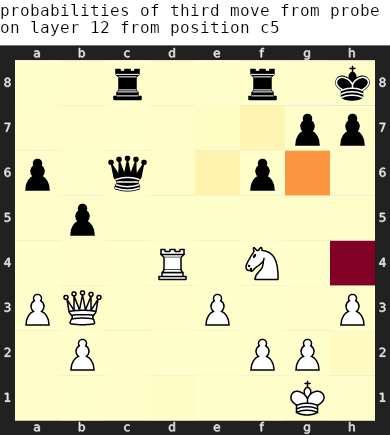

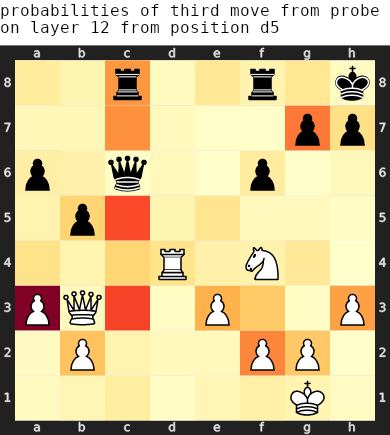

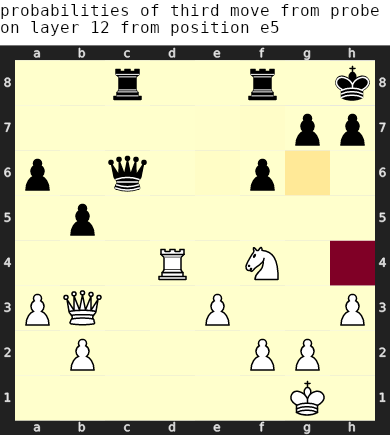

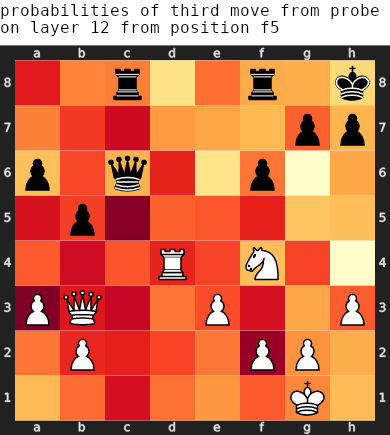

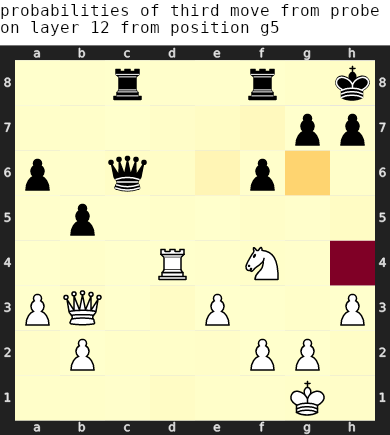

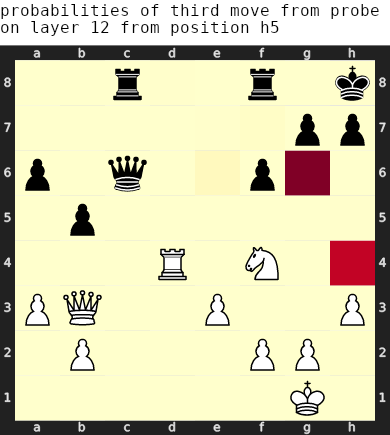

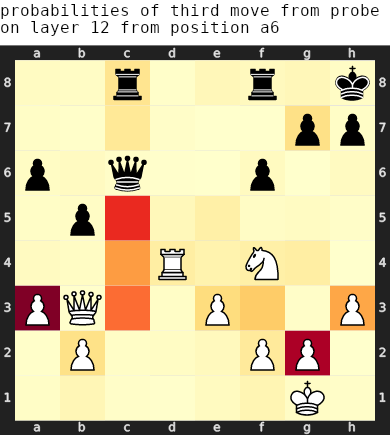

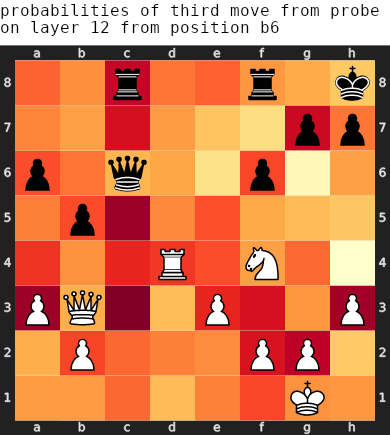

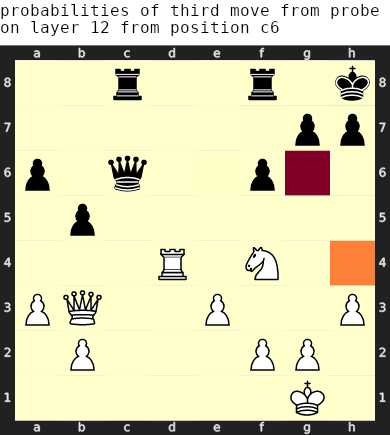

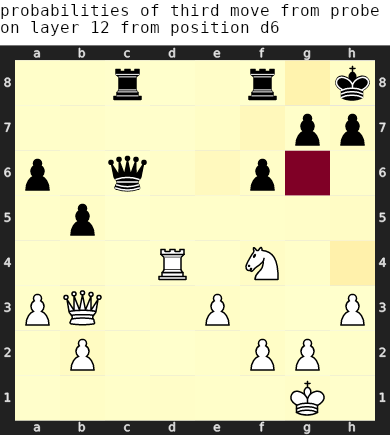

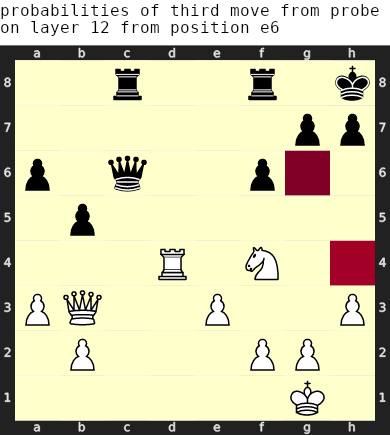

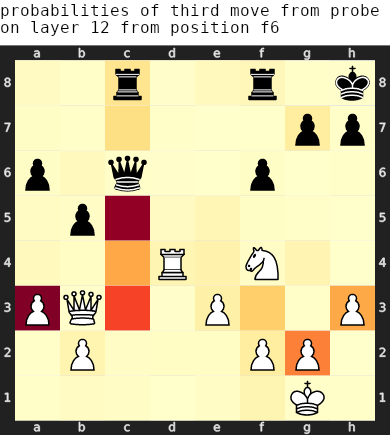

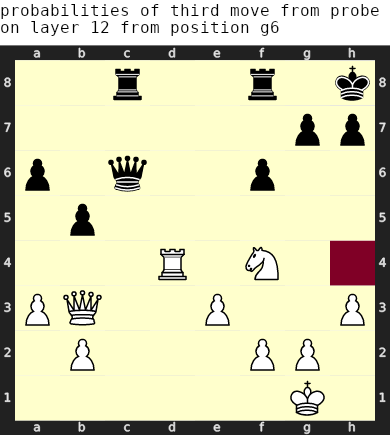

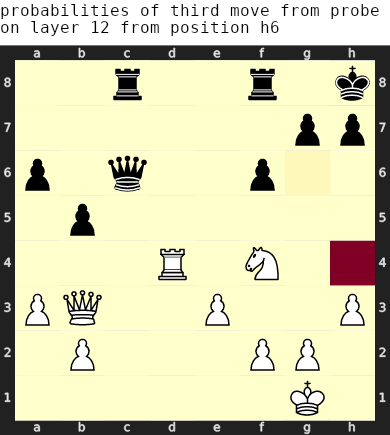

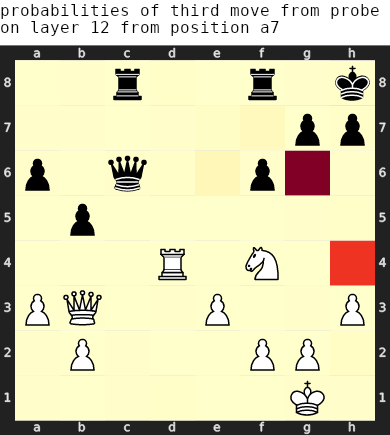

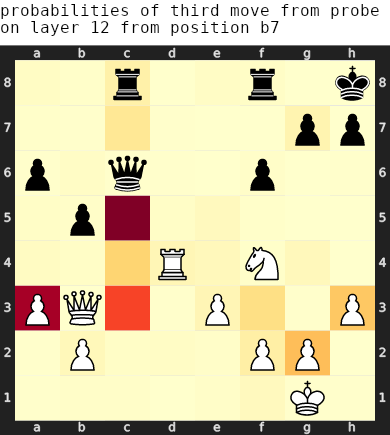

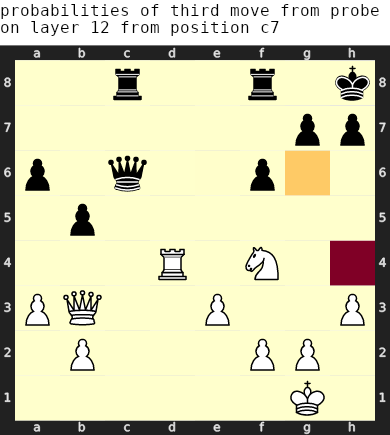

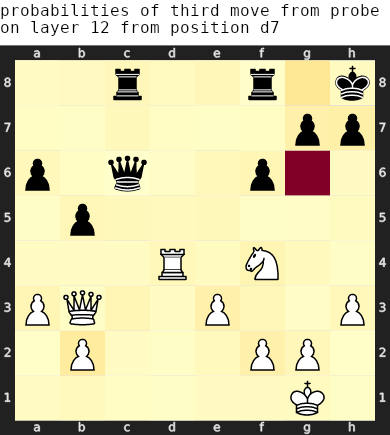

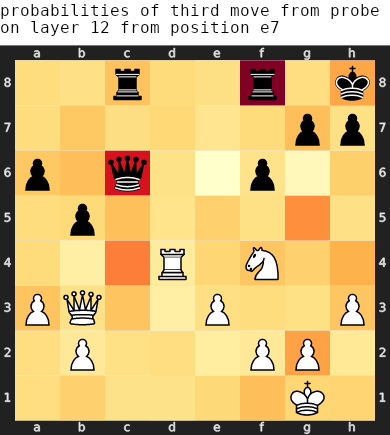

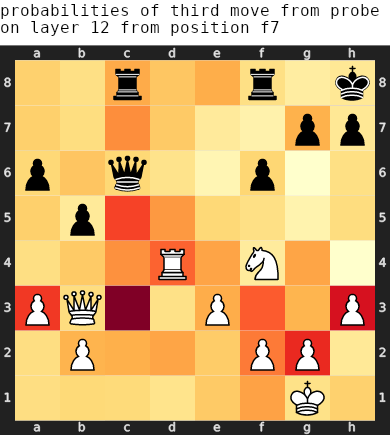

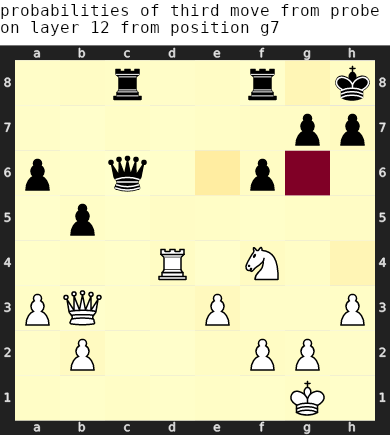

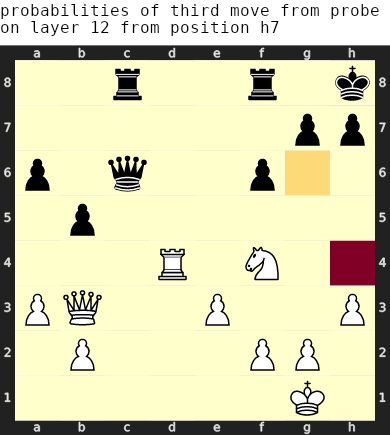

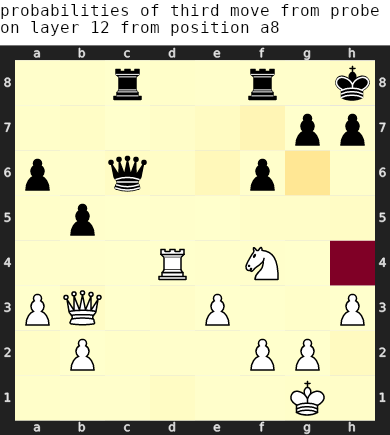

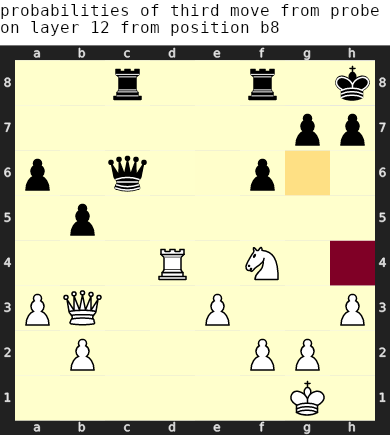

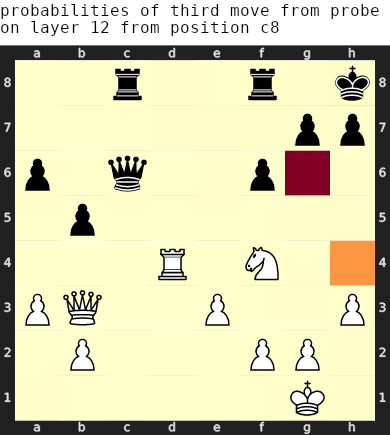

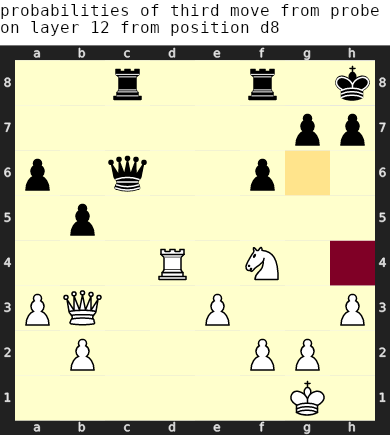

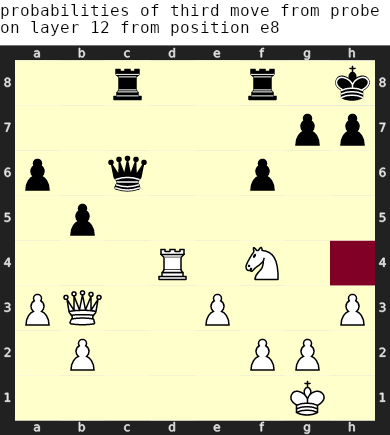

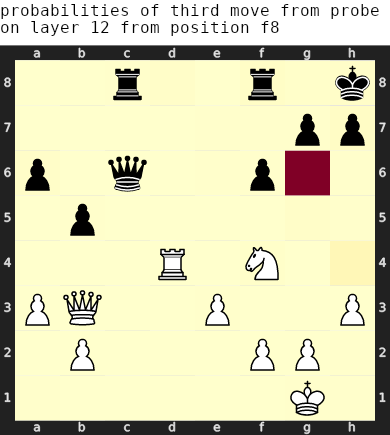

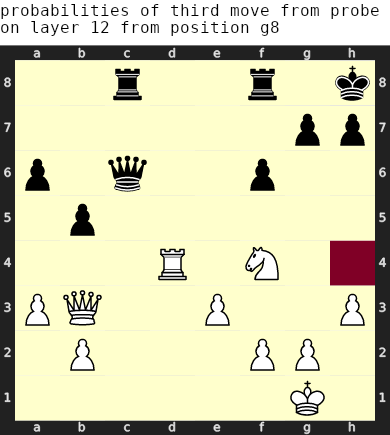

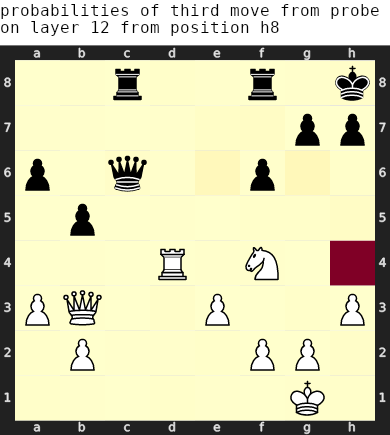

In [28]:
layer=12
for i in range(64):
    display( board.plot(target_probe_prediction(target_probes,i,layer=layer)[0], caption=f"probabilities of third move from probe on layer {layer} from position {board.idx2sq(i)}"))